In [1]:
import kagglehub
from kagglehub import KaggleDatasetAdapter

import pandas as pd

pd.set_option('display.float_format', '{:.2f}'.format)

/opt/anaconda3/envs/IoT/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Daily usage dataset

It is important to understand that this dataset contains one sample/household/day for up to 5000+ households. That means that for each day there can be 5000+ samples.  

It is not the same as the dataset of assignment 2, which only contains one sample x day for a single household.

In [2]:


df = pd.read_csv("Dataset/daily_dataset.csv")


print("First 5 records:", df.head())


First 5 records:        LCLid         day  energy_median  energy_mean  energy_max  \
0  MAC000131  2011-12-15           0.48         0.43        0.87   
1  MAC000131  2011-12-16           0.14         0.30        1.12   
2  MAC000131  2011-12-17           0.10         0.19        0.69   
3  MAC000131  2011-12-18           0.11         0.22        0.68   
4  MAC000131  2011-12-19           0.19         0.33        0.79   

   energy_count  energy_std  energy_sum  energy_min  
0            22        0.24        9.51        0.07  
1            48        0.28       14.22        0.03  
2            48        0.19        9.11        0.06  
3            48        0.20       10.51        0.07  
4            48        0.26       15.65        0.07  


In [3]:
# Convert the 'day' column to datetime format

df["day"] = pd.to_datetime(df["day"])

<Axes: >

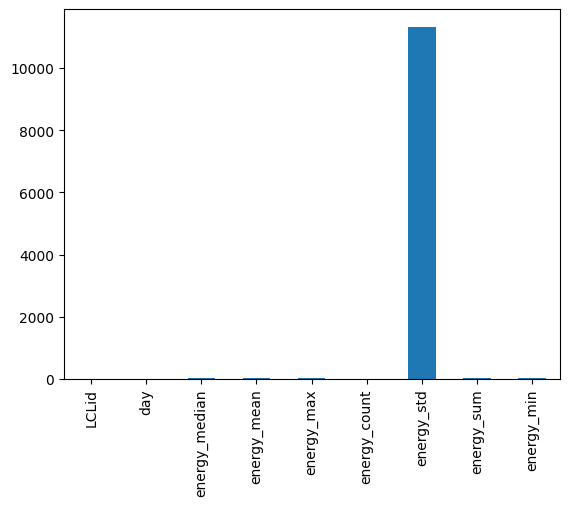

In [4]:
df.isna().sum().plot.bar()

Not a lot NAs, let's drop them.

In [5]:
df_clean = df.dropna()

In [6]:
df_clean.shape

(3499102, 9)

The variables in the dataset are statistics for that day (total, mean, median, quartiles, std), for a given household (identified by LCLid). The statistics are derived from that household's hourly readings. So they refer to hourly readings which have only one value ("quantity" of electricity).

As such either one of them could be used as the response variable, but none can be used as an explanatory variable.

This poses a bit of a problem since we cannot train a model with only one variable (although date-time can also be considered a variable, more on that later).

In [7]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3499102 entries, 0 to 3510431
Data columns (total 9 columns):
 #   Column         Dtype         
---  ------         -----         
 0   LCLid          object        
 1   day            datetime64[ns]
 2   energy_median  float64       
 3   energy_mean    float64       
 4   energy_max     float64       
 5   energy_count   int64         
 6   energy_std     float64       
 7   energy_sum     float64       
 8   energy_min     float64       
dtypes: datetime64[ns](1), float64(6), int64(1), object(1)
memory usage: 267.0+ MB


In addition, not all households are reporting consistently throughout the time period. There is a "ramp-up" period from ~ 2012 to 2013. This means that we shouldn't use an aggregated variable (like total energy for all households / day) as an accurate representation of energy consumption since it increases over time, not due to an increase in consumption, but due to an increase in the number of households reporting in.

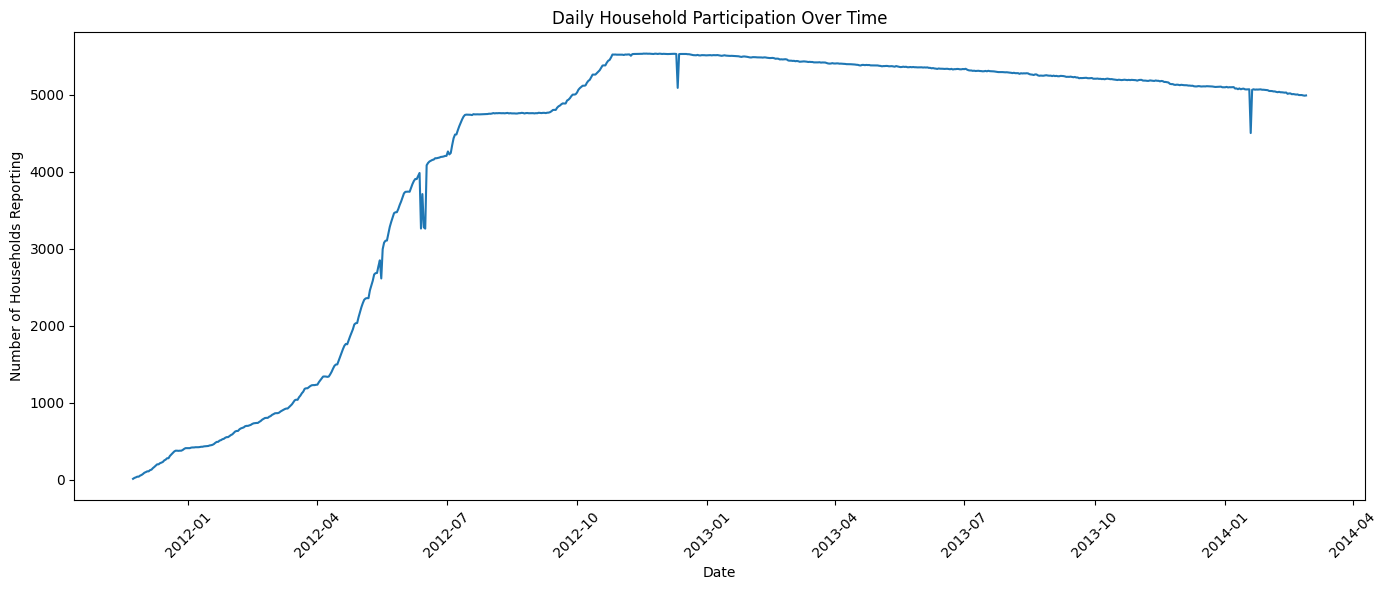

In [8]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Count distinct households per day
households_per_day = df_clean.groupby('day')['LCLid'].nunique().sort_index()

# Create line graph
plt.figure(figsize=(14, 6))
plt.plot(households_per_day.index, households_per_day.values)
plt.xlabel('Date')
plt.ylabel('Number of Households Reporting')
plt.title('Daily Household Participation Over Time')

# Format x-axis to show fewer labels
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))  # Show every 3 months
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Exploratory data analysis

Doing descriptive statistics on the datasets gives us an idea of the distribution of each variables. 

Because those variables are themselves statistics, it becomes a bit awkward:

- The mean of the mean?
- The std of the std?
- The min of the min?
- The median of the median?

What is actually happening is that the variable "mean" represents the mean/day/household. So looking at the mean of the "mean" variable means looking at the mean of the mean/day/household for all days for all households. In other words it gives us the average electricity consumption for all households, for all days. 

The mean of the "std" variable gives us the average standard deviation in electricity consumption for all households, for all days.

Etc.

In [9]:
df_clean[[
    "energy_min",
    "energy_max",
    "energy_mean",
    "energy_median",
    "energy_sum",
    "energy_std"
]].describe()

,energy_min,energy_max,energy_mean,energy_median,energy_sum,energy_std
count,3499102.00,3499102.00,3499102.00,3499102.00,3499102.00,3499102.00
mean,0.06,0.84,0.21,0.16,10.16,0.17
std,0.09,0.67,0.19,0.17,9.13,0.15
min,0.00,0.00,0.00,0.00,0.00,0.00
25%,0.02,0.35,0.10,0.07,4.71,0.07
50%,0.04,0.69,0.16,0.11,7.84,0.13
75%,0.07,1.13,0.26,0.19,12.59,0.23
max,6.39,10.76,6.93,6.97,332.56,4.02


I was reviewing the Smart_meters_in_london notebook and I wanted to understand what is meant by "Median consumption values are consistently lower than mean values, indicating **right-skewed distributions**". 

So I plotted the distribution of each variable (histogram first then boxplot). Indeed for each variables, we see a majority of the readings are on the lower end but there is a lot of high amplitude outliers.

In [ ]:
import math

def drawDashboard3(keys, num_col):

    n_plots = len(keys)
    num_rows = int(math.ceil(n_plots / num_col))

    plt.figure(figsize=(6,12))
    for i in range(n_plots):
        plt.subplot(num_rows, num_col, i+1)
        plt.hist(df_clean[keys[i]], edgecolor="black")
        plt.xlabel(keys[i])
    plt.tight_layout()
    plt.show()

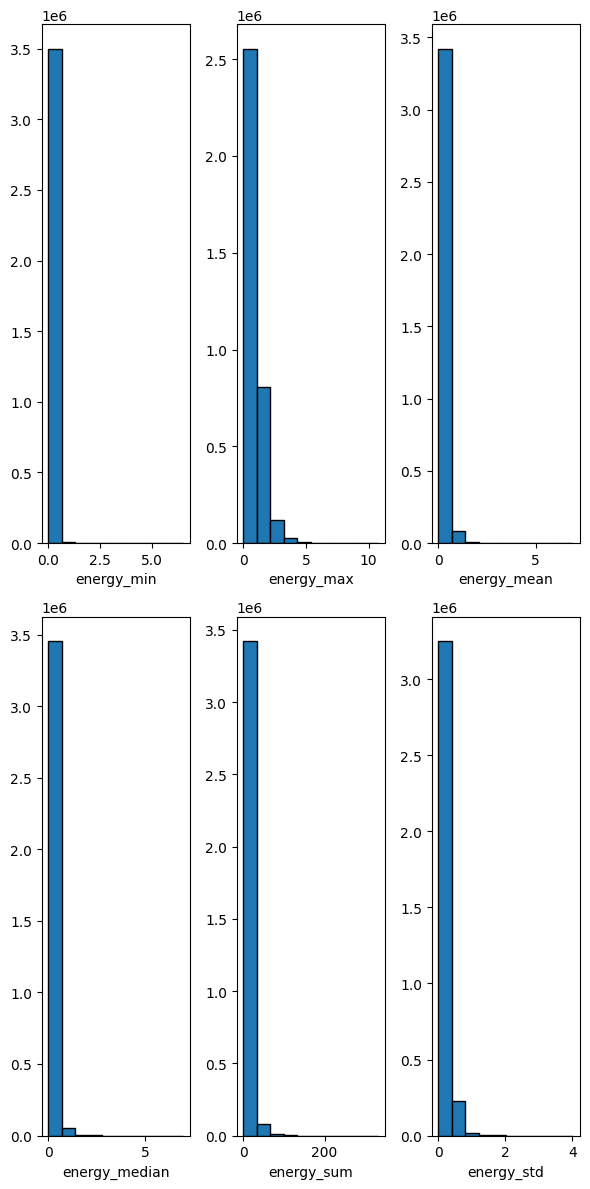

In [11]:
keys = [
    "energy_min",
    "energy_max",
    "energy_mean",
    "energy_median",
    "energy_sum",
    "energy_std"
]

drawDashboard3(keys, 3)

In [ ]:
def drawBoxplots(keys, num_col):
    n_plots = len(keys)
    num_rows = int(math.ceil(n_plots / num_col))
    
    plt.figure(figsize=(6, 12))
    for i in range(n_plots):
        plt.subplot(num_rows, num_col, i+1)
        plt.boxplot(df_clean[keys[i]].dropna())
        plt.xlabel(keys[i])
    plt.tight_layout()
    plt.show()

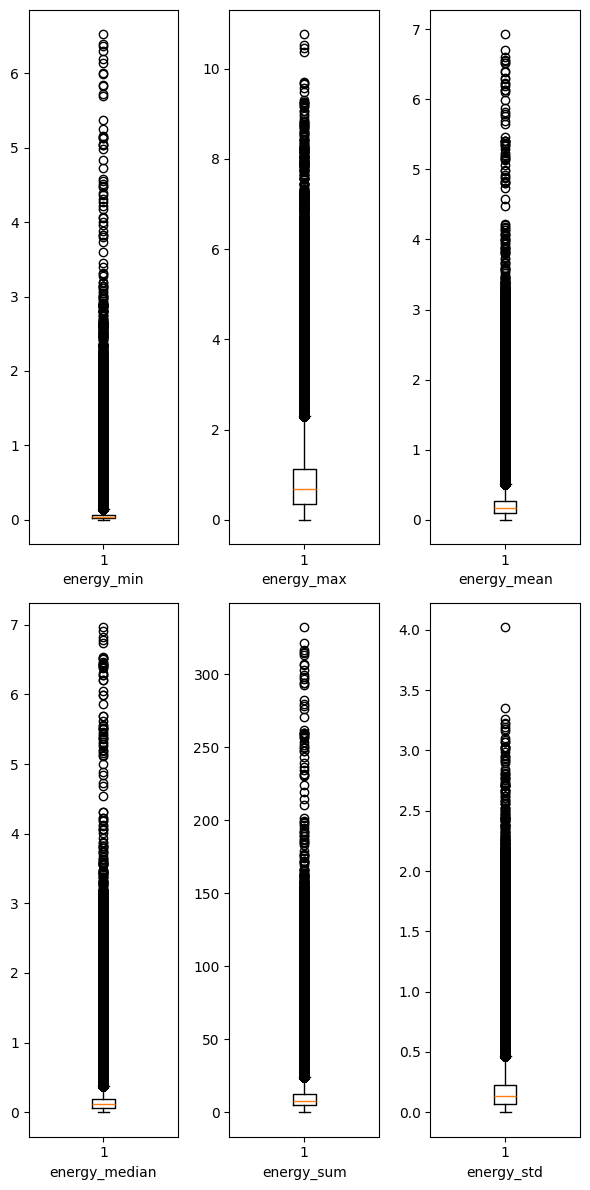

In [13]:
drawBoxplots(keys, 3)

That's all well and good, but I would like to see if we can isolate factors for each of these variables which have an effect on them. I will start by using date to give each row a "season" value:

In [ ]:
df_clean['season'] = df_clean['day'].dt.month.map({
    12: 'Winter', 1: 'Winter', 2: 'Winter',
    3: 'Spring', 4: 'Spring', 5: 'Spring',
    6: 'Summer', 7: 'Summer', 8: 'Summer',
    9: 'Fall', 10: 'Fall', 11: 'Fall'
})

/var/folders/ck/sr6gtz6n0jx9dmp9nlplxl_w0000gn/T/ipykernel_93544/435617862.py:11: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data_by_season, labels=seasons)
/var/folders/ck/sr6gtz6n0jx9dmp9nlplxl_w0000gn/T/ipykernel_93544/435617862.py:11: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data_by_season, labels=seasons)
/var/folders/ck/sr6gtz6n0jx9dmp9nlplxl_w0000gn/T/ipykernel_93544/435617862.py:11: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data_by_season, labels=seasons)
/var/folders/ck/sr6gtz6n0jx9dmp9nlplxl_w0000gn/T/ipykernel_93544/435617862.py:11: MatplotlibDeprecationWarnin

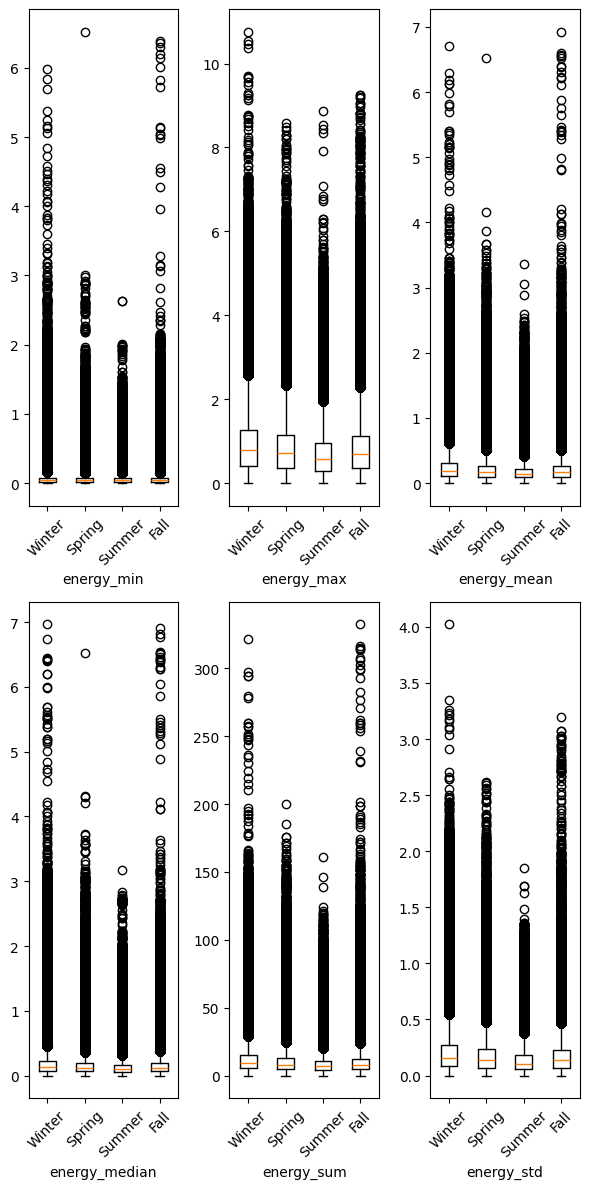

In [15]:
def drawBoxplotsBySeason(keys, num_col):
    n_plots = len(keys)
    num_rows = int(math.ceil(n_plots / num_col))
    
    seasons = ['Winter', 'Spring', 'Summer', 'Fall']
    
    plt.figure(figsize=(6, 12))
    for i in range(n_plots):
        plt.subplot(num_rows, num_col, i+1)
        data_by_season = [df_clean[df_clean['season'] == season][keys[i]].dropna() for season in seasons]
        plt.boxplot(data_by_season, labels=seasons)
        plt.xlabel(keys[i])
        plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

drawBoxplotsBySeason(keys, 3)

We can see that season does seem to have an effect on each variable, with Spring and Summer showing a noticeable contraction in the distribution of each variable.

Let's explore the dataset further to see what other external variable we could use for comparison.

# Acorn classification

ACORN means "A Classification Of Residential Neighbourhoods". It characterizes neighborhoods by their scores on 15 criteria:
- POPULATION
- HOUSING
- FAMILY
- ECONOMY
- EDUCATION
- HEALTH
- TRANSPORT
- MARKETING CHANNELS
- FINANCE
- DIGITAL
- SHOPPING
- CONTACT
- ENVIRONMENT
- COMMUNITY SAFETY
- LEISURE TIME

In [16]:
acorn_detail_df = pd.read_csv("Dataset/acorn_details.csv", encoding='latin-1')
acorn_detail_df.head()

,MAIN CATEGORIES,CATEGORIES,REFERENCE,ACORN-A,ACORN-B,ACORN-C,ACORN-D,ACORN-E,ACORN-F,ACORN-G,ACORN-H,ACORN-I,ACORN-J,ACORN-K,ACORN-L,ACORN-M,ACORN-N,ACORN-O,ACORN-P,ACORN-Q
0,POPULATION,Age,Age 0-4,77.00,83.00,72.00,100.00,120.00,77.00,97.00,97.00,63.00,119.00,67.00,114.00,113.00,89.00,123.00,138.00,133.00
1,POPULATION,Age,Age 5-17,117.00,109.00,87.00,69.00,94.00,95.00,102.00,106.00,67.00,95.00,64.00,108.00,116.00,86.00,89.00,136.00,106.00
2,POPULATION,Age,Age 18-24,64.00,73.00,67.00,107.00,100.00,71.00,83.00,89.00,62.00,104.00,459.00,97.00,96.00,86.00,117.00,109.00,110.00
3,POPULATION,Age,Age 25-34,52.00,63.00,62.00,197.00,151.00,66.00,90.00,88.00,63.00,132.00,145.00,109.00,96.00,90.00,140.00,120.00,120.00
4,POPULATION,Age,Age 35-49,102.00,105.00,91.00,124.00,118.00,93.00,102.00,103.00,76.00,111.00,67.00,99.00,98.00,90.00,102.00,103.00,100.00


In [17]:
acorn_detail_df['MAIN CATEGORIES'].nunique()

15

In [18]:
acorn_detail_df['MAIN CATEGORIES'].unique()

array(['POPULATION', 'HOUSING', 'FAMILY', 'ECONOMY', 'EDUCATION',
       'HEALTH', 'TRANSPORT', 'MARKETING CHANNELS', 'FINANCE', 'DIGITAL',
       'SHOPPING', 'CONTACT', 'ENVIRONMENT', 'COMMUNITY SAFETY',
       'LEISURE TIME'], dtype=object)

The `informations_household` dataset contains the mapping table between LCLid (household unique identifier) and the Acorn group (Adversity/Comfortable/Affluent). 

We can do a join of the two datasets on LCLid to add the Acorn_grouped column to the original dataset.

In [19]:
household_info_df = pd.read_csv("Dataset/informations_households.csv")

household_info_df.head()

,LCLid,stdorToU,Acorn,Acorn_grouped,file
0,MAC005492,ToU,ACORN-,ACORN-,block_0
1,MAC001074,ToU,ACORN-,ACORN-,block_0
2,MAC000002,Std,ACORN-A,Affluent,block_0
3,MAC003613,Std,ACORN-A,Affluent,block_0
4,MAC003597,Std,ACORN-A,Affluent,block_0


In [20]:
# merge with household info
household_info_df = pd.read_csv("Dataset/informations_households.csv")
usage_acorn_df = df_clean.merge(household_info_df, on='LCLid', how='left')

usage_acorn_df.head()

,LCLid,day,energy_median,energy_mean,energy_max,energy_count,energy_std,energy_sum,energy_min,stdorToU,Acorn,Acorn_grouped,file
0,MAC000131,2011-12-15,0.48,0.43,0.87,22,0.24,9.51,0.07,Std,ACORN-E,Affluent,block_22
1,MAC000131,2011-12-16,0.14,0.30,1.12,48,0.28,14.22,0.03,Std,ACORN-E,Affluent,block_22
2,MAC000131,2011-12-17,0.10,0.19,0.69,48,0.19,9.11,0.06,Std,ACORN-E,Affluent,block_22
3,MAC000131,2011-12-18,0.11,0.22,0.68,48,0.20,10.51,0.07,Std,ACORN-E,Affluent,block_22
4,MAC000131,2011-12-19,0.19,0.33,0.79,48,0.26,15.65,0.07,Std,ACORN-E,Affluent,block_22


Let's check for NAs.

In [21]:
usage_acorn_df['Acorn_grouped'].isna().sum()

np.int64(0)

Lets check the possible values of Acorn_grouped.

In [22]:
usage_acorn_df['Acorn_grouped'].unique()

array(['Affluent', 'Adversity', 'Comfortable', 'ACORN-U', 'ACORN-'],
      dtype=object)

What is ACORN-U and ACORN?

In [23]:
usage_acorn_df['Acorn_grouped'].value_counts()

Acorn_grouped
Affluent       1403523
Adversity      1131208
Comfortable     934155
ACORN-U          29439
ACORN-             777
Name: count, dtype: int64

Let's calculate the percentages for each

In [24]:
# calculate the percentages of each Acorn group
acorn_counts = usage_acorn_df['Acorn_grouped'].value_counts()
acorn_percentages = (acorn_counts / acorn_counts.sum()) * 100
acorn_percentages

Acorn_grouped
Affluent      40.11
Adversity     32.33
Comfortable   26.70
ACORN-U        0.84
ACORN-         0.02
Name: count, dtype: float64

Let's drop them.

In [25]:
# drop ACORN-U and ACORN-

usage_acorn_df = usage_acorn_df[~usage_acorn_df['Acorn_grouped'].isin(['ACORN-U', 'ACORN-'])]

Now let's plot the how the data is distributed for each acorn group.

/var/folders/ck/sr6gtz6n0jx9dmp9nlplxl_w0000gn/T/ipykernel_93544/2315855459.py:11: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data_by_acorn, labels=acorn_groups)
/var/folders/ck/sr6gtz6n0jx9dmp9nlplxl_w0000gn/T/ipykernel_93544/2315855459.py:11: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data_by_acorn, labels=acorn_groups)
/var/folders/ck/sr6gtz6n0jx9dmp9nlplxl_w0000gn/T/ipykernel_93544/2315855459.py:11: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data_by_acorn, labels=acorn_groups)
/var/folders/ck/sr6gtz6n0jx9dmp9nlplxl_w0000gn/T/ipykernel_93544/2315855459.py:11: MatplotlibD

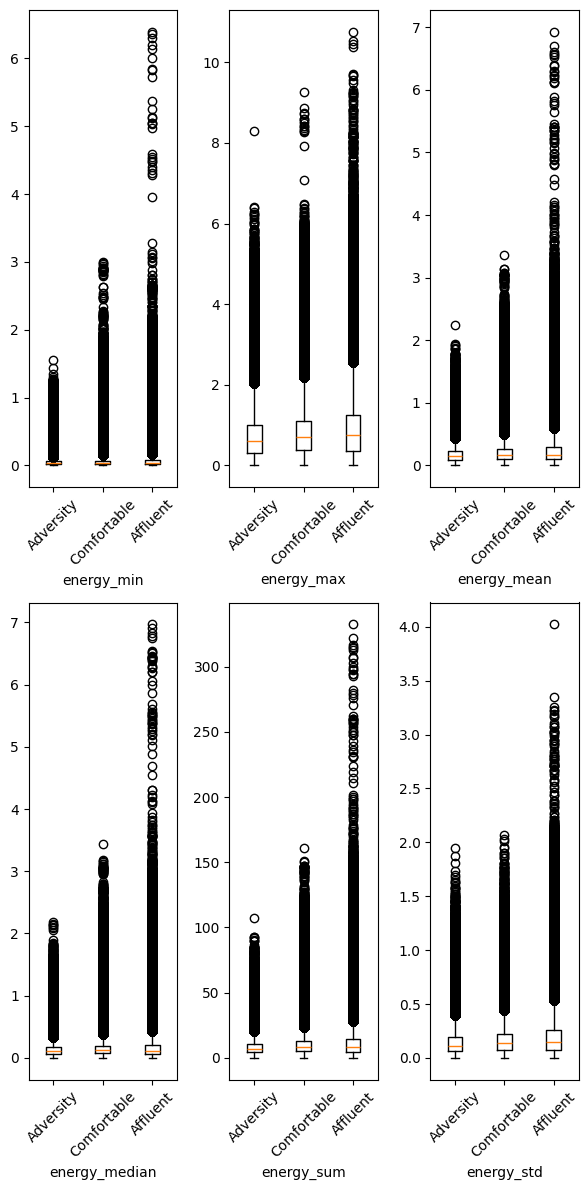

In [26]:
def drawBoxplotsByAcornGroup(keys, num_col):
    n_plots = len(keys)
    num_rows = int(math.ceil(n_plots / num_col))
    
    acorn_groups = ['Adversity', 'Comfortable', 'Affluent']
    
    plt.figure(figsize=(6, 12))
    for i in range(n_plots):
        plt.subplot(num_rows, num_col, i+1)
        data_by_acorn = [usage_acorn_df[usage_acorn_df['Acorn_grouped'] == group][keys[i]].dropna() for group in acorn_groups]
        plt.boxplot(data_by_acorn, labels=acorn_groups)
        plt.xlabel(keys[i])
        plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

drawBoxplotsByAcornGroup(keys, 3)

The distributions are different for each acorn group, indicating that the level of affluence of the neighborhoods has an effect on energy consumption, with the more affluent households consuming more energy.

# Time Of Use tariff (TOU)

There was another flag that was included in the acorn file. It is called "stdorToU", and it represents whether the household was put under Time of Use tariffs. 

Time of Use tariffs charge higher rates during peak demand hours (typically evenings) and lower rates during off-peak hours (like overnight) to incentivize shifting electricity usage to less congested times.

In [27]:
tou = household_info_df[(household_info_df["stdorToU"] == "ToU")]

tou.shape

(1123, 5)

In [28]:
tou["Acorn_grouped"].value_counts()

Acorn_grouped
Affluent       490
Comfortable    323
Adversity      298
ACORN-U         10
ACORN-           2
Name: count, dtype: int64

In [29]:
tou = household_info_df[(household_info_df["stdorToU"] == "Std")]

tou.shape

(4443, 5)

In [30]:
tou["Acorn_grouped"].value_counts()

Acorn_grouped
Affluent       1702
Adversity      1518
Comfortable    1184
ACORN-U          39
Name: count, dtype: int64

contingency table:
Acorn_grouped  ACORN-  ACORN-U  Adversity  Affluent  Comfortable
stdorToU                                                        
Std              0.00     0.01       0.34      0.38         0.27
ToU              0.00     0.01       0.27      0.44         0.29


<Axes: xlabel='stdorToU'>

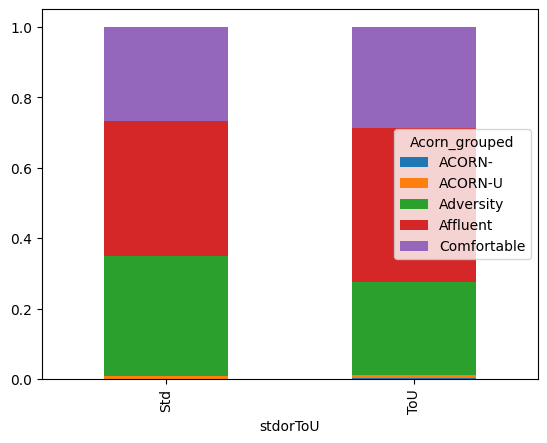

In [31]:
raw_table = pd.crosstab(household_info_df['stdorToU'], household_info_df['Acorn_grouped'], margins = False, normalize=True)

contingency_pct = raw_table.div(raw_table.sum(axis=1), axis=0)

print("contingency table:")
print(contingency_pct)

contingency_pct.plot(kind='bar', stacked=True)


The representation of each Acorn group is consistent across both TOU and Std households, cool it means we can compare their effect on energy consumption.

TypeError: list indices must be integers or slices, not str

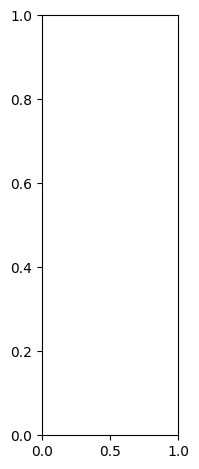

In [32]:

def create_Groups(dataset, groups):
    data_by_group = [dataset[dataset['stdorToU'] == group] for group in groups]
    return data_by_group


def drawBoxplotsByTariffGroup(keys, num_col, dataset):
    n_plots = len(keys)
    num_rows = int(math.ceil(n_plots / num_col))
    
    tariff_groups = ['ToU', 'Std']
    
    plt.figure(figsize=(6, 12))
    for i in range(n_plots):
        plt.subplot(num_rows, num_col, i+1)

        data_by_group = create_Groups(dataset, tariff_groups)
        
        keyed = data_by_group[keys[i]].dropna()

        
        plt.boxplot(keyed, labels=tariff_groups)
        plt.xlabel(keys[i])
        plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

drawBoxplotsByTariffGroup(keys, 3, usage_acorn_df)

This too seems to have an effect on energy consumption (at least on the outliers).